# Probability
:label:`sec_prob`

In some form or another, machine learning is all about making predictions.
We might want to predict the *probability* of a patient suffering a heart attack in the next year, given their clinical history. In anomaly detection, we might want to assess how *likely* a set of readings from an airplane's jet engine would be, were it operating normally. In reinforcement learning, we want an agent to act intelligently in an environment. This means we need to think about the probability of getting a high reward under each of the available actions. And when we build recommender systems we also need to think about probability. For example, say *hypothetically* that we worked for a large online bookseller. We might want to estimate the probability that a particular user would buy a particular book. For this we need to use the language of probability.
Entire courses, majors, theses, careers, and even departments, are devoted to probability. So naturally, our goal in this section is not to teach the whole subject. Instead we hope to get you off the ground, to teach you just enough that you can start building your first deep learning models, and to give you enough of a flavor for the subject that you can begin to explore it on your own if you wish.

We have already invoked probabilities in previous sections without articulating what precisely they are or giving a concrete example. Let us get more serious now by considering the first case: distinguishing cats and dogs based on photographs. This might sound simple but it is actually a formidable challenge. To start with, the difficulty of the problem may depend on the resolution of the image.

![Images of varying resolutions ($10 \times 10$, $20 \times 20$, $40 \times 40$, $80 \times 80$, and $160 \times 160$ pixels).](../img/cat-dog-pixels.png)
:width:`300px`
:label:`fig_cat_dog`

As shown in :numref:`fig_cat_dog`,
while it is easy for humans to recognize cats and dogs at the resolution of $160 \times 160$ pixels,
it becomes challenging at $40 \times 40$ pixels and next to impossible at $10 \times 10$ pixels. In
other words, our ability to tell cats and dogs apart at a large distance (and thus low resolution) might approach uninformed guessing. Probability gives us a
formal way of reasoning about our level of certainty.
If we are completely sure
that the image depicts a cat, we say that the *probability* that the corresponding label $y$ is "cat", denoted $P(y=$ "cat"$)$ equals $1$.
If we had no evidence to suggest that $y =$ "cat" or that $y =$ "dog", then we might say that the two possibilities were equally
*likely* expressing this as $P(y=$ "cat"$) = P(y=$ "dog"$) = 0.5$. If we were reasonably
confident, but not sure that the image depicted a cat, we might assign a
probability $0.5  < P(y=$ "cat"$) < 1$.

Now consider the second case: given some weather monitoring data, we want to predict the probability that it will rain in Taipei tomorrow. If it is summertime, the rain might come with probability 0.5.

In both cases, we have some value of interest. And in both cases we are uncertain about the outcome.
But there is a key difference between the two cases. In this first case, the image is in fact either a dog or a cat, and we just do not know which. In the second case, the outcome may actually be a random event, if you believe in such things (and most physicists do). So probability is a flexible language for reasoning about our level of certainty, and it can be applied effectively in a broad set of contexts.

## Basic Probability Theory

Say that we cast a die and want to know what the chance is of seeing a 1 rather than another digit. If the die is fair, all the six outcomes $\{1, \ldots, 6\}$ are equally likely to occur, and thus we would see a $1$ in one out of six cases. Formally we state that $1$ occurs with probability $\frac{1}{6}$.

For a real die that we receive from a factory, we might not know those proportions and we would need to check whether it is tainted. The only way to investigate the die is by casting it many times and recording the outcomes. For each cast of the die, we will observe a value in $\{1, \ldots, 6\}$. Given these outcomes, we want to investigate the probability of observing each outcome.

One natural approach for each value is to take the
individual count for that value and to divide it by the total number of tosses.
This gives us an *estimate* of the probability of a given *event*. The *law of
large numbers* tell us that as the number of tosses grows this estimate will draw closer and closer to the true underlying probability. Before going into the details of what is going here, let us try it out.

To start, let us import the necessary packages.


In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from d2l import tensorflow as d2l

Next, we will want to be able to cast the die. In statistics we call this process
of drawing examples from probability distributions *sampling*.
The distribution
that assigns probabilities to a number of discrete choices is called the
*multinomial distribution*. We will give a more formal definition of
*distribution* later, but at a high level, think of it as just an assignment of
probabilities to events.

To draw a single sample, we simply pass in a vector of probabilities.
The output is another vector of the same length:
its value at index $i$ is the number of times the sampling outcome corresponds to $i$.


In [2]:
fair_probs = tf.ones(6) / 6
tfp.distributions.Multinomial(1, fair_probs).sample()

2022-01-14 03:04:48.750252: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-01-14 03:04:49.112791: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0.], dtype=float32)>

If you run the sampler a bunch of times, you will find that you get out random
values each time. As with estimating the fairness of a die, we often want to
generate many samples from the same distribution. It would be unbearably slow to
do this with a Python `for` loop, so the function we are using supports drawing
multiple samples at once, returning an array of independent samples in any shape
we might desire.


In [3]:
tfp.distributions.Multinomial(10, fair_probs).sample()

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 1., 3., 2., 2., 1.], dtype=float32)>

Now that we know how to sample rolls of a die, we can simulate 1000 rolls. We
can then go through and count, after each of the 1000 rolls, how many times each
number was rolled.
Specifically, we calculate the relative frequency as the estimate of the true probability.


In [4]:
counts = tfp.distributions.Multinomial(1000, fair_probs).sample()
counts / 1000

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0.177, 0.175, 0.152, 0.151, 0.182, 0.163], dtype=float32)>

Because we generated the data from a fair die, we know that each outcome has true probability $\frac{1}{6}$, roughly $0.167$, so the above output estimates look good.

We can also visualize how these probabilities converge over time towards the true probability.
Let us conduct 500 groups of experiments where each group draws 10 samples.


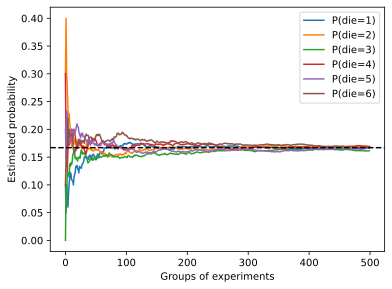

In [5]:
counts = tfp.distributions.Multinomial(10, fair_probs).sample(500)
cum_counts = tf.cumsum(counts, axis=0)
estimates = cum_counts / tf.reduce_sum(cum_counts, axis=1, keepdims=True)

d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(),
                 label=("P(die=" + str(i + 1) + ")"))
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

Each solid curve corresponds to one of the six values of the die and gives our estimated probability that the die turns up that value as assessed after each group of experiments.
The dashed black line gives the true underlying probability.
As we get more data by conducting more experiments,
the $6$ solid curves converge towards the true probability.

### Axioms of Probability Theory

When dealing with the rolls of a die,
we call the set $\mathcal{S} = \{1, 2, 3, 4, 5, 6\}$ the *sample space* or *outcome space*, where each element is an *outcome*.
An *event* is a set of outcomes from a given sample space.
For instance, "seeing a $5$" ($\{5\}$) and "seeing an odd number" ($\{1, 3, 5\}$) are both valid events of rolling a die.
Note that if the outcome of a random experiment is in event $\mathcal{A}$,
then event $\mathcal{A}$ has occurred.
That is to say, if $3$ dots faced up after rolling a die, since $3 \in \{1, 3, 5\}$,
we can say that the event "seeing an odd number" has occurred.

Formally, *probability* can be thought of as a function that maps a set to a real value.
The probability of an event $\mathcal{A}$ in the given sample space $\mathcal{S}$,
denoted as $P(\mathcal{A})$, satisfies the following properties:

* For any event $\mathcal{A}$, its probability is never negative, i.e., $P(\mathcal{A}) \geq 0$;
* Probability of the entire sample space is $1$, i.e., $P(\mathcal{S}) = 1$;
* For any countable sequence of events $\mathcal{A}_1, \mathcal{A}_2, \ldots$ that are *mutually exclusive* ($\mathcal{A}_i \cap \mathcal{A}_j = \emptyset$ for all $i \neq j$), the probability that any happens is equal to the sum of their individual probabilities, i.e., $P(\bigcup_{i=1}^{\infty} \mathcal{A}_i) = \sum_{i=1}^{\infty} P(\mathcal{A}_i)$.

These are also the axioms of probability theory, proposed by Kolmogorov in 1933.
Thanks to this axiom system, we can avoid any philosophical dispute on randomness;
instead, we can reason rigorously with a mathematical language.
For instance, by letting event $\mathcal{A}_1$ be the entire sample space and $\mathcal{A}_i = \emptyset$ for all $i > 1$, we can prove that $P(\emptyset) = 0$, i.e., the probability of an impossible event is $0$.


### Random Variables

In our random experiment of casting a die, we introduced the notion of a *random variable*. A random variable can be pretty much any quantity and is not deterministic. It could take one value among a set of possibilities in a random experiment.
Consider a random variable $X$ whose value is in the sample space $\mathcal{S} = \{1, 2, 3, 4, 5, 6\}$ of rolling a die. We can denote the event "seeing a $5$" as $\{X = 5\}$ or $X = 5$, and its probability as $P(\{X = 5\})$ or $P(X = 5)$.
By $P(X = a)$, we make a distinction between the random variable $X$ and the values (e.g., $a$) that $X$ can take.
However, such pedantry results in a cumbersome notation.
For a compact notation,
on one hand, we can just denote $P(X)$ as the *distribution* over the random variable $X$:
the distribution tells us the probability that $X$ takes any value.
On the other hand,
we can simply write $P(a)$ to denote the probability that a random variable takes the value $a$.
Since an event in probability theory is a set of outcomes from the sample space,
we can specify a range of values for a random variable to take.
For example, $P(1 \leq X \leq 3)$ denotes the probability of the event $\{1 \leq X \leq 3\}$,
which means $\{X = 1, 2, \text{or}, 3\}$. Equivalently, $P(1 \leq X \leq 3)$ represents the probability that the random variable $X$ can take a value from $\{1, 2, 3\}$.

Note that there is a subtle difference between *discrete* random variables, like the sides of a die, and *continuous* ones, like the weight and the height of a person. There is little point in asking whether two people have exactly the same height. If we take precise enough measurements you will find that no two people on the planet have the exact same height. In fact, if we take a fine enough measurement, you will not have the same height when you wake up and when you go to sleep. So there is no purpose in asking about the probability
that someone is 1.80139278291028719210196740527486202 meters tall. Given the world population of humans the probability is virtually 0. It makes more sense in this case to ask whether someone's height falls into a given interval, say between 1.79 and 1.81 meters. In these cases we quantify the likelihood that we see a value as a *density*. The height of exactly 1.80 meters has no probability, but nonzero density. In the interval between any two different heights we have nonzero probability.
In the rest of this section, we consider probability in discrete space.
For probability over continuous random variables, you may refer to :numref:`sec_random_variables`.

## Dealing with Multiple Random Variables

Very often, we will want to consider more than one random variable at a time.
For instance, we may want to model the relationship between diseases and symptoms. Given a disease and a symptom, say "flu" and "cough", either may or may not occur in a patient with some probability. While we hope that the probability of both would be close to zero, we may want to estimate these probabilities and their relationships to each other so that we may apply our inferences to effect better medical care.

As a more complicated example, images contain millions of pixels, thus millions of random variables. And in many cases images will come with a
label, identifying objects in the image. We can also think of the label as a
random variable. We can even think of all the metadata as random variables
such as location, time, aperture, focal length, ISO, focus distance, and camera type.
All of these are random variables that occur jointly. When we deal with multiple random variables, there are several quantities of interest.

### Joint Probability

The first is called the *joint probability* $P(A = a, B=b)$. Given any values $a$ and $b$, the joint probability lets us answer, what is the probability that $A=a$ and $B=b$ simultaneously?
Note that for any values $a$ and $b$, $P(A=a, B=b) \leq P(A=a)$.
This has to be the case, since for $A=a$ and $B=b$ to happen, $A=a$ has to happen *and* $B=b$ also has to happen (and vice versa). Thus, $A=a$ and $B=b$ cannot be more likely than $A=a$ or $B=b$ individually.


### Conditional Probability

This brings us to an interesting ratio: $0 \leq \frac{P(A=a, B=b)}{P(A=a)} \leq 1$. We call this ratio a *conditional probability*
and denote it by $P(B=b \mid A=a)$: it is the probability of $B=b$, provided that
$A=a$ has occurred.

### Bayes' theorem

Using the definition of conditional probabilities, we can derive one of the most useful and celebrated equations in statistics: *Bayes' theorem*.
It goes as follows.
By construction, we have the *multiplication rule* that $P(A, B) = P(B \mid A) P(A)$. By symmetry, this also holds for $P(A, B) = P(A \mid B) P(B)$. Assume that $P(B) > 0$. Solving for one of the conditional variables we get

$$P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}.$$

Note that here we use the more compact notation where $P(A, B)$ is a *joint distribution* and $P(A \mid B)$ is a *conditional distribution*. Such distributions can be evaluated for particular values $A = a, B=b$.

### Marginalization

Bayes' theorem is very useful if we want to infer one thing from the other, say cause and effect, but we only know the properties in the reverse direction, as we will see later in this section. One important operation that we need, to make this work, is *marginalization*.
It is the operation of determining $P(B)$ from $P(A, B)$. We can see that the probability of $B$ amounts to accounting for all possible choices of $A$ and aggregating the joint probabilities over all of them:

$$P(B) = \sum_{A} P(A, B),$$

which is also known as the *sum rule*. The probability or distribution as a result of marginalization is called a *marginal probability* or a *marginal distribution*.


### Independence

Another useful property to check for is *dependence* vs. *independence*.
Two random variables $A$ and $B$ being independent
means that the occurrence of one event of $A$
does not reveal any information about the occurrence of an event of $B$.
In this case $P(B \mid A) = P(B)$. Statisticians typically express this as $A \perp  B$. From Bayes' theorem, it follows immediately that also $P(A \mid B) = P(A)$.
In all the other cases we call $A$ and $B$ dependent. For instance, two successive rolls of a die are independent. In contrast, the position of a light switch and the brightness in the room are not (they are not perfectly deterministic, though, since we could always have a broken light bulb, power failure, or a broken switch).

Since $P(A \mid B) = \frac{P(A, B)}{P(B)} = P(A)$ is equivalent to $P(A, B) = P(A)P(B)$, two random variables are independent if and only if their joint distribution is the product of their individual distributions.
Likewise, two random variables $A$ and $B$ are *conditionally independent* given another random variable $C$
if and only if $P(A, B \mid C) = P(A \mid C)P(B \mid C)$. This is expressed as $A \perp B \mid C$.

### Application
:label:`subsec_probability_hiv_app`

Let us put our skills to the test. Assume that a doctor administers an HIV test to a patient. This test is fairly accurate and it fails only with 1% probability if the patient is healthy but reporting him as diseased. Moreover,
it never fails to detect HIV if the patient actually has it. We use $D_1$ to indicate the diagnosis ($1$ if positive and $0$ if negative) and $H$ to denote the HIV status ($1$ if positive and $0$ if negative).
:numref:`conditional_prob_D1` lists such conditional probabilities.

:Conditional probability of $P(D_1 \mid H)$.

| Conditional probability | $H=1$ | $H=0$ |
|---|---|---|
|$P(D_1 = 1 \mid H)$|            1 |         0.01 |
|$P(D_1 = 0 \mid H)$|            0 |         0.99 |
:label:`conditional_prob_D1`

Note that the column sums are all 1 (but the row sums are not), since the conditional probability needs to sum up to 1, just like the probability. Let us work out the probability of the patient having HIV if the test comes back positive, i.e., $P(H = 1 \mid D_1 = 1)$. Obviously this is going to depend on how common the disease is, since it affects the number of false alarms. Assume that the population is quite healthy, e.g., $P(H=1) = 0.0015$. To apply Bayes' theorem, we need to apply marginalization and the multiplication rule to determine

$$\begin{aligned}
&P(D_1 = 1) \\
=& P(D_1=1, H=0) + P(D_1=1, H=1)  \\
=& P(D_1=1 \mid H=0) P(H=0) + P(D_1=1 \mid H=1) P(H=1) \\
=& 0.011485.
\end{aligned}
$$

Thus, we get

$$\begin{aligned}
&P(H = 1 \mid D_1 = 1)\\ =& \frac{P(D_1=1 \mid H=1) P(H=1)}{P(D_1=1)} \\ =& 0.1306 \end{aligned}.$$

In other words, there is only a 13.06% chance that the patient
actually has HIV, despite using a very accurate test.
As we can see, probability can be counterintuitive.

What should a patient do upon receiving such terrifying news? Likely, the patient
would ask the physician to administer another test to get clarity. The second
test has different characteristics and it is not as good as the first one, as shown in :numref:`conditional_prob_D2`.


:Conditional probability of $P(D_2 \mid H)$.

| Conditional probability | $H=1$ | $H=0$ |
|---|---|---|
|$P(D_2 = 1 \mid H)$|            0.98 |         0.03 |
|$P(D_2 = 0 \mid H)$|            0.02 |         0.97 |
:label:`conditional_prob_D2`

Unfortunately, the second test comes back positive, too.
Let us work out the requisite probabilities to invoke Bayes' theorem
by assuming the conditional independence:

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1 \mid H = 0) \\
=& P(D_1 = 1 \mid H = 0) P(D_2 = 1 \mid H = 0)  \\
=& 0.0003,
\end{aligned}
$$

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1 \mid H = 1) \\
=& P(D_1 = 1 \mid H = 1) P(D_2 = 1 \mid H = 1)  \\
=& 0.98.
\end{aligned}
$$

Now we can apply marginalization and the multiplication rule:

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1) \\
=& P(D_1 = 1, D_2 = 1, H = 0) + P(D_1 = 1, D_2 = 1, H = 1)  \\
=& P(D_1 = 1, D_2 = 1 \mid H = 0)P(H=0) + P(D_1 = 1, D_2 = 1 \mid H = 1)P(H=1)\\
=& 0.00176955.
\end{aligned}
$$

In the end, the probability of the patient having HIV given both positive tests is

$$\begin{aligned}
&P(H = 1 \mid D_1 = 1, D_2 = 1)\\
=& \frac{P(D_1 = 1, D_2 = 1 \mid H=1) P(H=1)}{P(D_1 = 1, D_2 = 1)} \\
=& 0.8307.
\end{aligned}
$$

That is, the second test allowed us to gain much higher confidence that not all is well. Despite the second test being considerably less accurate than the first one, it still significantly improved our estimate.



## Expectation and Variance

To summarize key characteristics of probability distributions,
we need some measures.
The *expectation* (or average) of the random variable $X$ is denoted as

$$E[X] = \sum_{x} x P(X = x).$$

When the input of a function $f(x)$ is a random variable drawn from the distribution $P$ with different values $x$,
the expectation of $f(x)$ is computed as

$$E_{x \sim P}[f(x)] = \sum_x f(x) P(x).$$


In many cases we want to measure by how much the random variable $X$ deviates from its expectation. This can be quantified by the variance

$$\mathrm{Var}[X] = E\left[(X - E[X])^2\right] =
E[X^2] - E[X]^2.$$

Its square root is called the *standard deviation*.
The variance of a function of a random variable measures
by how much the function deviates from the expectation of the function,
as different values $x$ of the random variable are sampled from its distribution:

$$\mathrm{Var}[f(x)] = E\left[\left(f(x) - E[f(x)]\right)^2\right].$$


## Summary

* We can sample from probability distributions.
* We can analyze multiple random variables using joint distribution, conditional distribution, Bayes' theorem, marginalization, and independence assumptions.
* Expectation and variance offer useful measures to summarize key characteristics of probability distributions.


## Exercises

1. We conducted $m=500$ groups of experiments where each group draws $n=10$ samples. Vary $m$ and $n$. Observe and analyze the experimental results.
1. Given two events with probability $P(\mathcal{A})$ and $P(\mathcal{B})$, compute upper and lower bounds on $P(\mathcal{A} \cup \mathcal{B})$ and $P(\mathcal{A} \cap \mathcal{B})$. (Hint: display the situation using a [Venn Diagram](https://en.wikipedia.org/wiki/Venn_diagram).)
1. Assume that we have a sequence of random variables, say $A$, $B$, and $C$, where $B$ only depends on $A$, and $C$ only depends on $B$, can you simplify the joint probability $P(A, B, C)$? (Hint: this is a [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain).)
1. In :numref:`subsec_probability_hiv_app`, the first test is more accurate. Why not run the first test twice rather than run both the first and second tests?


[Discussions](https://discuss.d2l.ai/t/198)
